<a href="https://colab.research.google.com/github/NehaAgarwal2598/election_parameters/blob/master/election_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data from Github repo

In [1]:
!git clone https://github.com/ayan59dutta/election_parameters.git

Cloning into 'election_parameters'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 50 (delta 23), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (50/50), done.


# Load data from file into dataframes

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
colmn_list = ['Candidate', 'Constituency', 'Criminal Case', 'Education', 'Total Assets', 'Liabilities']

def convert(x):
    return int(x.split()[1].replace(',', '').replace('~', ''))

df1_cand_details = pd.read_excel('election_parameters/data/MyNeta_UP_Assembly_ELections_2017.xlsx',
                          usecols=colmn_list,
                          converters={'Candidate': lambda x:x.upper(),
                                     'Total Assets': convert,
                                     'Liabilities': convert})

df1_cand_details['Net Assets'] = df1_cand_details['Total Assets'] - df1_cand_details['Liabilities']
df1_cand_details = df1_cand_details.drop(columns=['Total Assets', 'Liabilities'])
df1_cand_details.rename(columns={'Candidate': 'CAND_NAME', 
                                 'Constituency': 'AC_NAME', 
                                 'Criminal Case': 'C_CASE',
                                 'Education': 'EDU', 
                                 'Net Assets': 'NET_ASSETS'}, 
                        inplace=True)
df1_cand_details

,CAND_NAME,AC_NAME,C_CASE,EDU,NET_ASSETS
0,A HASIV,ARYA NAGAR,0,12th Pass,33578492
1,A WAHID,GAINSARI,0,10th Pass,75106
2,AAN SHIKHAR SHRIVASTAVA,GOSHAINGANJ,0,Graduate,41000
3,AAPTAB URF AFTAB,MUBARAKPUR,0,Illiterate,20000
4,AASHI GAUR,KHATAULI,0,Literate,3468543
5,AASHIF BEG,BARKHERA,0,Not Given,1330000
6,AATMA RAM,PURQAZI (SC),1,12th Pass,2326259
7,AATMARAM,TULSIPUR,0,Literate,782500
8,ABBAS AHMAD,MARIYAHU,1,Literate,1131432
9,ABBAS ALI ZAIDI URF RUSHDI MIYAN,RUDAULI,0,Graduate,20602366


In [4]:
colmn_list = ['ST_CODE', 'AC_NAME', 'AC_TYPE', 'CAND_NAME', 'CAND_SEX', 
              'CAND_CATEGORY', 'CAND_AGE', 'TOTVOTPOLL', 'POSITION']

df_ae12 = pd.read_excel('election_parameters/data/AE2012_8913.xls',
                        usecols=colmn_list,
                        header=1,
                        converters={'AC_NAME': lambda x: x.upper()})

df_ae12 = df_ae12[df_ae12.ST_CODE == 'S24']

df_ae12 = df_ae12.drop('ST_CODE', axis=1).reset_index().drop('index', axis=1)

df_ae12

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTVOTPOLL,POSITION
0,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,50,70274,1
1,BEHAT,GEN,NARESH,M,GEN,47,69760,2
2,BEHAT,GEN,UMAR ALI KHAN,M,GEN,34,47366,3
3,BEHAT,GEN,AJAY CHAUHAN,M,GEN,29,23623,4
4,BEHAT,GEN,DHARAM SINGH,M,SC,39,2251,5
5,BEHAT,GEN,DHANIRAM,M,GEN,39,1774,6
6,BEHAT,GEN,ARVIND,M,GEN,31,1399,7
7,BEHAT,GEN,KARI INAM,M,GEN,35,1308,8
8,BEHAT,GEN,YASHPAL,M,SC,28,781,9
9,BEHAT,GEN,ABDUL JABBAR,M,GEN,35,726,10


In [5]:
la_2017 = pd.read_excel('election_parameters/data/LA_2017.xls', 
                        usecols = [1, 6, 7, 8, 9,10, 11, 13, 14], 
                        converters={'AC_NAME': lambda x:x.upper(),
                                    'CAND_NAME': lambda x: x.upper()})
la_2017  = la_2017.drop(la_2017[la_2017.ST_NAME != 'Uttar Pradesh'].index)
la_2017 = la_2017.drop('ST_NAME', axis = 1).reset_index().drop('index', axis=1)
la_2017

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION
0,BEHAT,GEN,NARESH SAINI,M,GEN,53.0,97035,1
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55.0,71449,2
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52.0,71019,3
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49.0,4187,4
4,BEHAT,GEN,NONE OF THE ABOVE,NaN,NaN,NaN,1576,5
5,BEHAT,GEN,KAMRAN ALI,M,GEN,37.0,1255,6
6,BEHAT,GEN,ARUN,M,GEN,38.0,1150,7
7,BEHAT,GEN,HARDHYAN,M,SC,39.0,1113,8
8,BEHAT,GEN,GOPAL SINGH,M,GEN,32.0,945,9
9,BEHAT,GEN,KRISHNA KUMAR,M,SC,35.0,810,10


## Anti-Incumbency Check

In [0]:
# winners_ae12 = df_ae12[df_ae12['POSITION'] == 1]
# #winners_ae12 

# no_of_winners_12and17 = 0
# no_of_winners_12not17 = 0
# no_of_winners_12abs17 = 0

# for index, row in winners_ae12.iterrows():
#   #print(row.CAND_NAME)
#   if row.CAND_NAME in la_2017['CAND_NAME']:
#     print(row.CAND_NAME)
#     break
# else:
#   print('Over')
  
# set1 = set(winners_ae12.CAND_NAME)
# set1
# set2 = set(la_2017.CAND_NAME)
# set2
# set12 = set1.intersection(set2)
# set12

In [7]:
la_2017.CAND_NAME

0                      NARESH SAINI
1               MAHAVEER SINGH RANA
2                       MOHD. IQBAL
3          RANA ADITYA PRATAP SINGH
4                 NONE OF THE ABOVE
5                        KAMRAN ALI
6                              ARUN
7                          HARDHYAN
8                       GOPAL SINGH
9                     KRISHNA KUMAR
10                     KALYAN SINGH
11                     LOKESH VERMA
12                      SAKEEM KHAN
13                       KARM SINGH
14            DR.DHARAM SINGH SAINI
15                     IMRAN MASOOD
16                 NAVEEN CHOUDHARY
17                NONE OF THE ABOVE
18                       KAMAL GARG
19                   VIJAYPAL SINGH
20                     RAJPAL SINGH
21                         RAMKUMAR
22                    PARVESH KUMAR
23                             INDU
24                      RAJIV SAINI
25                           ARVIND
26                      SANJAY GARG
27                     RAJIV

## Join the dataframes

In [8]:
la17_df = la_2017.merge(right=df1_cand_details, 
                        how='left',
                        on=['AC_NAME', 'CAND_NAME'])
la17_df

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION,C_CASE,EDU,NET_ASSETS
0,BEHAT,GEN,NARESH SAINI,M,GEN,53.0,97035,1,0.0,Post Graduate,10382291.0
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55.0,71449,2,0.0,Graduate Professional,52678213.0
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52.0,71019,3,0.0,Literate,129888857.0
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49.0,4187,4,0.0,12th Pass,65633483.0
4,BEHAT,GEN,NONE OF THE ABOVE,NaN,NaN,NaN,1576,5,NaN,NaN,NaN
5,BEHAT,GEN,KAMRAN ALI,M,GEN,37.0,1255,6,0.0,10th Pass,682859.0
6,BEHAT,GEN,ARUN,M,GEN,38.0,1150,7,2.0,12th Pass,9372508.0
7,BEHAT,GEN,HARDHYAN,M,SC,39.0,1113,8,0.0,5th Pass,2277500.0
8,BEHAT,GEN,GOPAL SINGH,M,GEN,32.0,945,9,0.0,10th Pass,102925.0
9,BEHAT,GEN,KRISHNA KUMAR,M,SC,35.0,810,10,NaN,NaN,NaN


### Dropping NOTA

In [9]:
la17_df = la17_df[la17_df.CAND_NAME != 'NONE OF THE ABOVE']
la17_df

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION,C_CASE,EDU,NET_ASSETS
0,BEHAT,GEN,NARESH SAINI,M,GEN,53.0,97035,1,0.0,Post Graduate,10382291.0
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55.0,71449,2,0.0,Graduate Professional,52678213.0
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52.0,71019,3,0.0,Literate,129888857.0
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49.0,4187,4,0.0,12th Pass,65633483.0
5,BEHAT,GEN,KAMRAN ALI,M,GEN,37.0,1255,6,0.0,10th Pass,682859.0
6,BEHAT,GEN,ARUN,M,GEN,38.0,1150,7,2.0,12th Pass,9372508.0
7,BEHAT,GEN,HARDHYAN,M,SC,39.0,1113,8,0.0,5th Pass,2277500.0
8,BEHAT,GEN,GOPAL SINGH,M,GEN,32.0,945,9,0.0,10th Pass,102925.0
9,BEHAT,GEN,KRISHNA KUMAR,M,SC,35.0,810,10,NaN,NaN,NaN
10,BEHAT,GEN,KALYAN SINGH,M,GEN,45.0,659,11,NaN,NaN,NaN


### Dropping NaN values

In [10]:
la17_df = la17_df.dropna().reset_index(drop=True)
la17_df

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION,C_CASE,EDU,NET_ASSETS
0,BEHAT,GEN,NARESH SAINI,M,GEN,53.0,97035,1,0.0,Post Graduate,10382291.0
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55.0,71449,2,0.0,Graduate Professional,52678213.0
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52.0,71019,3,0.0,Literate,129888857.0
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49.0,4187,4,0.0,12th Pass,65633483.0
4,BEHAT,GEN,KAMRAN ALI,M,GEN,37.0,1255,6,0.0,10th Pass,682859.0
5,BEHAT,GEN,ARUN,M,GEN,38.0,1150,7,2.0,12th Pass,9372508.0
6,BEHAT,GEN,HARDHYAN,M,SC,39.0,1113,8,0.0,5th Pass,2277500.0
7,BEHAT,GEN,GOPAL SINGH,M,GEN,32.0,945,9,0.0,10th Pass,102925.0
8,BEHAT,GEN,LOKESH VERMA,M,GEN,34.0,617,12,0.0,Post Graduate,288275.0
9,BEHAT,GEN,SAKEEM KHAN,M,GEN,42.0,425,13,0.0,Literate,14768000.0


### Change datatypes of columns from float to int

In [11]:
la17_df = la17_df.astype({"CAND_AGE": int, "C_CASE" : int, "NET_ASSETS": int})
la17_df

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION,C_CASE,EDU,NET_ASSETS
0,BEHAT,GEN,NARESH SAINI,M,GEN,53,97035,1,0,Post Graduate,10382291
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55,71449,2,0,Graduate Professional,52678213
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52,71019,3,0,Literate,129888857
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49,4187,4,0,12th Pass,65633483
4,BEHAT,GEN,KAMRAN ALI,M,GEN,37,1255,6,0,10th Pass,682859
5,BEHAT,GEN,ARUN,M,GEN,38,1150,7,2,12th Pass,9372508
6,BEHAT,GEN,HARDHYAN,M,SC,39,1113,8,0,5th Pass,2277500
7,BEHAT,GEN,GOPAL SINGH,M,GEN,32,945,9,0,10th Pass,102925
8,BEHAT,GEN,LOKESH VERMA,M,GEN,34,617,12,0,Post Graduate,288275
9,BEHAT,GEN,SAKEEM KHAN,M,GEN,42,425,13,0,Literate,14768000


## Set Targets

In [12]:
la17_df.loc[la17_df['POSITION'] == 1, 'POSITION'] = 1
la17_df.loc[la17_df['POSITION'] > 1, 'POSITION'] = 0
la17_df

,AC_NAME,AC_TYPE,CAND_NAME,CAND_SEX,CAND_CATEGORY,CAND_AGE,TOTALVALIDVOTESPOLLED,POSITION,C_CASE,EDU,NET_ASSETS
0,BEHAT,GEN,NARESH SAINI,M,GEN,53,97035,1,0,Post Graduate,10382291
1,BEHAT,GEN,MAHAVEER SINGH RANA,M,GEN,55,71449,0,0,Graduate Professional,52678213
2,BEHAT,GEN,MOHD. IQBAL,M,GEN,52,71019,0,0,Literate,129888857
3,BEHAT,GEN,RANA ADITYA PRATAP SINGH,M,GEN,49,4187,0,0,12th Pass,65633483
4,BEHAT,GEN,KAMRAN ALI,M,GEN,37,1255,0,0,10th Pass,682859
5,BEHAT,GEN,ARUN,M,GEN,38,1150,0,2,12th Pass,9372508
6,BEHAT,GEN,HARDHYAN,M,SC,39,1113,0,0,5th Pass,2277500
7,BEHAT,GEN,GOPAL SINGH,M,GEN,32,945,0,0,10th Pass,102925
8,BEHAT,GEN,LOKESH VERMA,M,GEN,34,617,0,0,Post Graduate,288275
9,BEHAT,GEN,SAKEEM KHAN,M,GEN,42,425,0,0,Literate,14768000


## K-Nearest Neighbors

In [13]:
features_names = ['CAND_NAME', 'CAND_SEX', 'CAND_CATEGORY', 'CAND_AGE', 'C_CASE', 'EDU', 'NET_ASSETS']
X = la17_df[features_names]
y = la17_df['POSITION']
X = pd.get_dummies(X)
X

,CAND_AGE,C_CASE,NET_ASSETS,CAND_NAME_A HASIV,CAND_NAME_A WAHID,CAND_NAME_AAN SHIKHAR SHRIVASTAVA,CAND_NAME_AASHI GAUR,CAND_NAME_AASHIF BEG,CAND_NAME_AATMARAM,CAND_NAME_ABBAS ALI ZAIDI URF RUSHDI MIYAN,CAND_NAME_ABBAS ANSARI,CAND_NAME_ABDUL KALAM,CAND_NAME_ABDUL MANNAN,CAND_NAME_ABDUL MAROOF KHAN,CAND_NAME_ABDUL MASHHOOD KHAN MASOOD,CAND_NAME_ABDUL RAHMAN,CAND_NAME_ABDUL RAUK,CAND_NAME_ABDUL SAMAD ANSARI,CAND_NAME_ABDUL WAHEED,CAND_NAME_ABDUL WARIS KHAN,CAND_NAME_ABHAY NATH TRIPATHI,CAND_NAME_ABHAY SINGH,CAND_NAME_ABHIJEET SINGH SANGA,CAND_NAME_ABHIMANYU,CAND_NAME_ABHIMANYU SINGH,CAND_NAME_ABHISHEK DWIVEDI,CAND_NAME_ABHISHEK KUMAR,CAND_NAME_ABHISHEK KUMAR SINGH,CAND_NAME_ABHISHEK MISHR,CAND_NAME_ABHISHEK SINGH,CAND_NAME_ABHISHESH,CAND_NAME_ABID,CAND_NAME_ABID ALI,CAND_NAME_ABID ANSARI,CAND_NAME_ABID RAZA KHAN,CAND_NAME_ABINAV RAJ,CAND_NAME_ABRAR AHMAD,CAND_NAME_ACHARYA SUBHASH CHANDRA TRIPATHI,CAND_NAME_ACHCHHE LAL,CAND_NAME_ADESH,...,CAND_NAME_YOGENDRA KUMAR,CAND_NAME_YOGENDRA PAL SINGH,CAND_NAME_YOGENDRA SINGH,CAND_NAME_YOGENDRAPAL SINGH,CAND_NAME_YOGESH CHAUDHARY,CAND_NAME_YOGESH DHAMA,CAND_NAME_YOGESH KUMAR,CAND_NAME_YOGESH PRATAP SINGH,CAND_NAME_YOGESH VERMA,CAND_NAME_YOGINI NIRMALA DEVI,CAND_NAME_YOGISH CHANDRA DUBEY,CAND_NAME_YOGRAJ SINGH,CAND_NAME_YUSUF,CAND_NAME_ZAFAR ALAM,CAND_NAME_ZAHID BEG,CAND_NAME_ZAHIR FATMA,CAND_NAME_ZAINUL ABEDIN,CAND_NAME_ZAKIR ALI,CAND_NAME_ZAKIR ALI RANA,CAND_NAME_ZAMEER ULLAH KHAN,CAND_NAME_ZEBA RIZWAN,CAND_NAME_ZURGHAM MEHDI,CAND_SEX_F,CAND_SEX_M,CAND_SEX_O,CAND_CATEGORY_GEN,CAND_CATEGORY_SC,CAND_CATEGORY_ST,EDU_10th Pass,EDU_12th Pass,EDU_5th Pass,EDU_8th Pass,EDU_Doctorate,EDU_Graduate,EDU_Graduate Professional,EDU_Illiterate,EDU_Literate,EDU_Not Given,EDU_Others,EDU_Post Graduate
0,53,0,10382291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,55,0,52678213,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,52,0,129888857,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,49,0,65633483,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,37,0,682859,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,38,2,9372508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,39,0,2277500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
7,32,0,102925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,34,0,288275,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9,42,0,14768000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
# X_train = OneHotEncoder(handle_unknown='ignore').fit(X_train)
# X_test = OneHotEncoder(handle_unknown='ignore').fit(X_test)

knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

In [16]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[541  11]
 [ 36   3]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       552
           1       0.21      0.08      0.11        39

    accuracy                           0.92       591
   macro avg       0.58      0.53      0.54       591
weighted avg       0.89      0.92      0.90       591



### Comparing Error Rate with the K Value

In [0]:
error = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

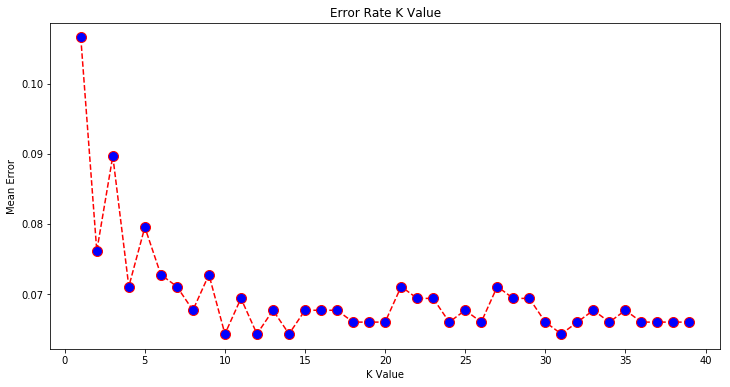

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')